<a href="https://colab.research.google.com/github/Renita1206/Bone-Fracture-Detection/blob/main/BoneFractureDetection-Draft1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and Setting up environment

In [4]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.2 MB/s 


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
import nibabel as nib
import random

In [31]:
# import libraries
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

## Setting up dataset from Kaggle

In [7]:
#https://www.kaggle.com/code/amineteffal/helloworld-rsna
! pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=128ceda815e1203bd6ae471798e3df78d733ed4a1315788e2e948ef9f35e2602
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bluecoder1206","key":"7a8821f20de2e4fcce76a3e92ffd556a"}'}

In [9]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download -d andradaolteanu/rsna-fracture-detection

100% 3.60G/3.61G [00:40<00:00, 97.8MB/s]
100% 3.61G/3.61G [00:40<00:00, 96.2MB/s]


In [12]:
!unzip rsna-fracture-detection.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/162.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/163.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/164.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/165.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/166.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/167.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/168.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/169.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/17.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/170.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/171.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/172.png  
  inflating: dataset/zip_png_images/1.2.826.0.1.3680043.9774/173.png  
  inflating: dataset/zip_pn

## Metafile EDA

In [15]:
train = pd.read_csv('/content/dataset/train.csv')
#print(train.info())
train.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,total_fractures
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,2
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,1
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,1
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,1
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0,1
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1,2
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1,1


In [16]:
def get_fractured_bones(patient_id):
    fractured_bones = []
    temp = train.loc[train.StudyInstanceUID == patient_id,['C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
    temp = list(temp.values[0]) # there is one row per id
    for i in range(len(temp)):
        if temp[i] == 1:
            fractured_bones.append('C' + str(i+1))
    return fractured_bones

In [17]:
get_fractured_bones('1.2.826.0.1.3680043.6200')

['C1', 'C2']

In [18]:
# get fractured and unfractured ids from train
fractured_ids = list(train.loc[train['patient_overall']==1,:]['StudyInstanceUID'])
unfractured_ids = list(train.loc[train['patient_overall']==0,:]['StudyInstanceUID'])
train_ids = fractured_ids + unfractured_ids
print('Number of ids from train : ', len(train_ids))
print('Number of unfractured ids from train : ', len(unfractured_ids))
print('Number of fractured ids from train : ', len(fractured_ids))

Number of ids from train :  2019
Number of unfractured ids from train :  1058
Number of fractured ids from train :  961


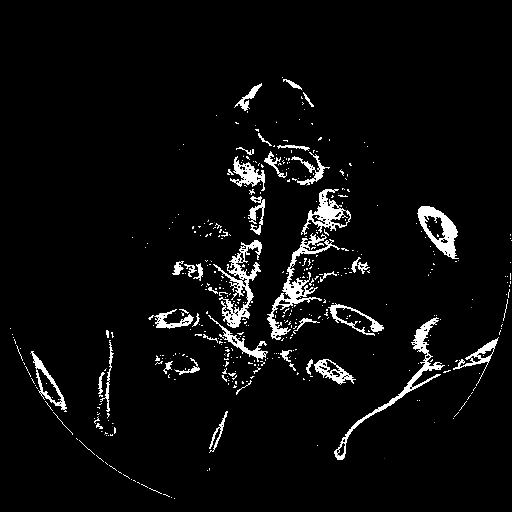

In [24]:
from google.colab.patches import cv2_imshow
from skimage import io

# path of train images /content/dataset/zip_png_images/1.2.826.0.1.3680043.10001/1.png
img = '/content/dataset/zip_png_images'
# some id
id1 = '1.2.826.0.1.3680043.6200'
# some slice of that id
slice_number = 136
# Read the file of that id and that slice number
img_path = img + '/' + id1 + '/' + str(slice_number) + '.png'
image = io.imread(img_path)
cv2_imshow(image)

In [25]:
str(get_fractured_bones(id1))

"['C1', 'C2']"

## Generate Training Dataset

In [28]:
cols = ['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] # for labels
path1 = '/content/dataset/zip_png_images'

def get_train_images(train_df, n_ids = 10, n_img = 10, img_size = (32, 32)):
    
    train_images = []
    train_labels = []
    
    # get n_ids ids at random
    ids = random.sample(list(train_df['StudyInstanceUID'].values), n_ids)
    
    
    for id_ in ids:
        # get labels for tha id_
        labels = train_df.loc[train_df['StudyInstanceUID'] == id_, cols].values[0]
       
        # file names of that id_
        id_files = os.listdir(path1 + '/' + id_)
        # read each of the dcm files
        for i in range(min(len(id_files), n_ids)):
            img_path = img + '/' + id1 + '/' + str(slice_number) + '.png'
            image = io.imread(img_path)
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            train_images.append(image)
            # add labels train_labels
            train_labels.append(labels)
    return np.array(train_images), np.array(train_labels)

In [29]:
get_train_images(train, 2, 2)[1].shape

(4, 8)

In [30]:
def generate_train_images(train_df, n_ids = 10, n_img = 10, img_size = (32, 32)):
    while 1:
        yield get_train_images(train_df, n_ids , n_img , img_size )

## Build and train Model

In [73]:
def get_model():
    img_input = layers.Input(shape=(32, 32,1))
    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv2D(16, 3, activation='relu')(img_input)
    x = layers.MaxPooling2D(2)(x)
    # Flatten feature map to a 1-dim tensor so we can add fully connected layers
    x = layers.Flatten()(x)
    # Create output layer with a single node and sigmoid activation
    output = layers.Dense(8, activation='sigmoid')(x)

    # Create model:
    model = Model(img_input, output)
    return model

In [33]:
model = get_model()

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 8)                 28808     
                                                                 
Total params: 28,968
Trainable params: 28,968
Non-trainable params: 0
_________________________________________________________

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
n_train_images = 711601

In [37]:
history = model.fit(generate_train_images(train,100,100), steps_per_epoch = 10, epochs = 1)

10/10 [==============================] - 225s 24s/step - loss: 0.4485 - acc: 0.7998


## Makeshift test

In [38]:
import shutil

In [63]:
shutil.move("/content/dataset/zip_png_images/1.2.826.0.1.3680043.6200", "/content/test")

'/content/test/1.2.826.0.1.3680043.6200'

In [69]:
def get_test_images(img_size = (32, 32)):
    path = '/content/test'
    test_images = []
    test_ids = []
    # test ids
    ids = ['1.2.826.0.1.3680043.6200','1.2.826.0.1.3680043.24617', '1.2.826.0.1.3680043.24593', '1.2.826.0.1.3680043.2467', '1.2.826.0.1.3680043.24673', '1.2.826.0.1.3680043.24704']
    
    
    for id_ in ids:
        # file names of that id_
        id_files = os.listdir(path + '/' + id_)
        # read each of the dcm files
        for i in range(len(id_files)):
            img_path = path + '/' + id1 + '/' + str(slice_number) + '.png'
            image = io.imread(img_path)
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            test_images.append(image)
            # add id_ to test_ids
            test_ids.append(id_)
    
    return np.array(test_images), np.array(test_ids)

In [70]:
test_images, test_ids = get_test_images()

In [71]:
results = model.predict(test_images)

62/62 [==============================] - 0s 6ms/step


In [72]:
results_df = pd.DataFrame(data=results, columns=cols)
results_df.insert(0, 'patient_id', test_ids)
results_df = results_df.melt(id_vars='patient_id', value_vars=cols, var_name='bone', value_name='fractured')
results_df.insert(0, 'row_id', results_df.patient_id + '_' + results_df.bone)
results_df.drop(['patient_id', 'bone'], axis=1, inplace=True)
results_df = pd.DataFrame(results_df.groupby(['row_id']).max().reset_index())
results_df.head(50)

,row_id,fractured
0,1.2.826.0.1.3680043.24593_C1,0.083904
1,1.2.826.0.1.3680043.24593_C2,0.155754
2,1.2.826.0.1.3680043.24593_C3,0.065468
3,1.2.826.0.1.3680043.24593_C4,0.078465
4,1.2.826.0.1.3680043.24593_C5,0.101193
5,1.2.826.0.1.3680043.24593_C6,0.151511
6,1.2.826.0.1.3680043.24593_C7,0.196166
7,1.2.826.0.1.3680043.24593_patient_overall,0.526557
8,1.2.826.0.1.3680043.24617_C1,0.083904
9,1.2.826.0.1.3680043.24617_C2,0.155754


In [67]:
str(get_fractured_bones('1.2.826.0.1.3680043.6200'))

"['C1', 'C2']"